### Load necessary libraries, models, and inintialize parameter variables

In [1]:
import os
import cv2
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt

# Allows PIL to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Appearance parameters for cv2 rectangles
#color = (255, 0, 0)
thickness = 4

dim = 640

# Load yolo segmentation model and KLD inference model
seg = torch.hub.load('ultralytics/yolov5', 'custom', path='static/models/best_yolo.pt') # NEW VERSION TRAINED ON AL-ALL

%matplotlib inline

C:\Users\matth\anaconda3\envs\flaskenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\matth/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-5-20 Python-3.7.16 torch-1.13.1+cpu CPU

Fusing layers... 


requirements: C:\Users\matth\anaconda3\envs\flaskenv\Lib\site-packages\requirements.txt not found, check failed.


Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [15]:
buff = 0.25
dim = 640
bdim = int( dim - (buff * 640) )
print(bdim)

colorspace = [(55, 131, 255), (77, 233, 76), (255, 140, 0), (255, 238, 0), (246, 0, 0), (0, 0, 0)]

480


### Define functions for segmentation, inferencing, and displaying results

In [16]:
# Function uses yolo model to find characters in image of papyrus fragments
def Segment(img_path):
    im = cv2.imread(img_path)[..., ::-1]
    #im = Image.open(img_path)#[..., ::-1]
    results = seg(im, size=640)
    df = results.pandas().xyxy[0]
    df.rename(columns = {'confidence':'yolo_confidence'}, inplace = True)
    #print(df)
    return df

def Iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

2328 1566


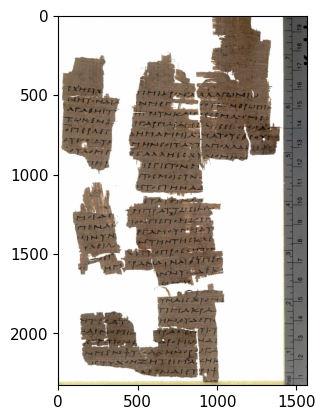

In [17]:
tim = cv2.imread("testimg.jpg")[..., ::-1]
h, w, c = tim.shape
print(h, w)
plt.imshow(tim)
plt.show()

In [18]:
xconvs = math.ceil(w / bdim)
yconvs = math.ceil(h / bdim)
print(xconvs, yconvs)


4 5


In [19]:
L = []
R = []
T = []
B = []
C = []
cc = []
subs = []

cs = 0
for j in range(yconvs):
    if j == 0:
        btm = 0
    else:
        btm  = (j * bdim) - 160
    top = btm + bdim -1
    if top > h:
        top = h
    if cs >= 4:
        cs = 0
    cs += 1
    #print(btm,top, "**********")
    for i in range(xconvs):
        if cs >= 4:
            cs = 0
        col = colorspace[cs]
        cs += 1
        if i == 0:
            left = 0
        else:
            left = i * bdim - 160
        right = left + bdim - 1
        if right > w:
            right = w
        #print(left, right)
        crop = tim[btm:top, left:right]
        subs.append([(left, btm), (right, top)])
        dat = seg(crop, size=640)
        df = dat.pandas().xyxy[0]
        df.rename(columns = {'confidence':'yolo_confidence'}, inplace = True)
        xmin = list(df.xmin)
        xmax = list(df.xmax)
        ymin = list(df.ymin)
        ymax = list(df.ymax)
        conf = list(df['yolo_confidence'])
        for k in range(len(xmin)):
            L.append(xmin[k] + left)
            R.append(xmax[k] + left)
            B.append(ymin[k] + btm)
            T.append(ymax[k] + btm)
            C.append(conf[k])
            cc.append(col)

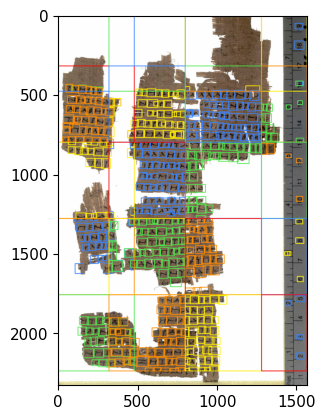

In [24]:
imgc = tim.copy()

for i in range(len(L)):
    sp = (int(L[i]), int(B[i]))
    ep = (int(R[i]), int(T[i]))
    
    imgc = cv2.rectangle(imgc, sp, ep, cc[i], thickness)
    #print(cc[i])
    
tog = 0
for i in range(len(subs)):
    sp = subs[i][0]
    ep = subs[i][1]
    if tog > 4:
        tog = 0
    imgc = cv2.rectangle(imgc, sp, ep, colorspace[tog], 4)
    tog += 1

plt.figure()
plt.imshow(imgc)
plt.savefig('yolo_out.png')
plt.show()

In [15]:
for j in range(len(L)):
    for i in range(len(L)):
        if i != j:
            ival1 = Iou([L[j], B[j], R[j], T[j]], [L[i], B[i], T[i], R[i]])
            ival2 = Iou([L[i], B[i], R[i], T[i]], [L[j], B[j], T[j], R[j]])
            ival = max(ival1, ival2)                                     
            if ival > 0.15:
                print(i, j, ival)
                print([L[j], B[j], R[j], T[j]])
                print([L[i], B[i], T[i], R[i]])
                print("*****************************************************")

117 69 0.1864159482981232
[766.6595458984375, 796.5682373046875, 824.2647705078125, 841.3349609375]
[818.7420043945312, 794.2730102539062, 841.4286499023438, 862.1245727539062]
*****************************************************
123 103 0.15395784459705433
[619.1651916503906, 598.7952880859375, 672.0017700195312, 644.6307373046875]
[562.8557968139648, 596.6966934204102, 641.7232055664062, 625.6017608642578]
*****************************************************
69 117 0.1864159482981232
[818.7420043945312, 794.2730102539062, 862.1245727539062, 841.4286499023438]
[766.6595458984375, 796.5682373046875, 841.3349609375, 824.2647705078125]
*****************************************************
103 123 0.15395784459705433
[562.8557968139648, 596.6966934204102, 625.6017608642578, 641.7232055664062]
[619.1651916503906, 598.7952880859375, 644.6307373046875, 672.0017700195312]
*****************************************************
